# import libraries and functions

In [1]:
import sys
import os

In [2]:
print(os.getcwd())

/home/jjoy/projects/BTE-RAG/notebooks


In [3]:
this_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(this_dir, os.pardir))
if project_root not in sys.path:
    sys.path.insert(0, project_root)
os.chdir(project_root)

In [4]:
print(os.getcwd())

/home/jjoy/projects/BTE-RAG


In [5]:
import kg_rag.util as funct
from kg_rag.util import * 


In [6]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

## functions

In [7]:
sentence_embedding_model='pritamdeka/S-PubMedBert-MS-MARCO'
embedding_function = load_sentence_transformer(sentence_embedding_model)

## Drug-entity-extraction

In [8]:
DRUG_ENTITY_EXTRACTION= """ You are an expert drug entity extractor from a sentence and report it as JSON in the following format:
  Drugs: <List of extracted entities>
  Please report only Drugs. Do not report any other entities like Diseases, Genes, Proteins, or Enzymes."""

In [9]:
def drug_entity_extractor_v2(text):
    chat_model_id, chat_deployment_id = get_gpt35()
    prompt_updated = DRUG_ENTITY_EXTRACTION + "\n" + "Sentence : " + text
    resp = get_GPT_response(prompt_updated, DRUG_ENTITY_EXTRACTION, chat_model_id, chat_deployment_id, temperature=0)
    try:
        entity_dict = json.loads(resp)
        return entity_dict["Drugs"]
    except:
        return None

## biobert

In [10]:
from sentence_transformers import SentenceTransformer, util
model = SentenceTransformer('pritamdeka/BioBERT-mnli-snli-scinli-scitail-mednli-stsb')

def safe_extract_text(cell):
    """Extract first string from a list or parse from a string-represented list."""
    if isinstance(cell, list):
        return cell[0] if cell else ''
    if isinstance(cell, str):
        try:
            parsed = ast.literal_eval(cell)
            if isinstance(parsed, list) and parsed:
                return parsed[0]
        except Exception:
            pass
        return cell
    return ''

def compute_biobert_cosine_similarity(df, list_col, str_col, output_col='cosine_similarity'):
    similarities = []

    for _, row in tqdm(df.iterrows(), total=len(df), desc="Calculating similarity"):
        text1 = safe_extract_text(row[list_col])
        text2 = str(row[str_col]) if pd.notna(row[str_col]) else ''
        
        if not text1.strip() or not text2.strip():
            similarities.append(None)
            continue
        
        try:
            emb1 = model.encode(text1, convert_to_tensor=True)
            emb2 = model.encode(text2, convert_to_tensor=True)
            score = util.pytorch_cos_sim(emb1, emb2).item()
            similarities.append(round(score,2))
        except Exception as e:
            print(f"Error at row: {text1}, {text2} -> {e}")
            similarities.append(None)

    df[output_col] = similarities
    return df

# Metabolite

We created a filtered dataset from DrugMechDB by applying several preprocessing steps to refine the set of drug–metabolite relationships. First, DrugBank identifiers were standardized by replacing the "DB:" prefix with "DRUGBANK:" in both the Drug_MeshID and drug columns. To focus on mechanistically relevant paths, we excluded any entries containing subclass relationships in the metapath_with_edges column. We then optionally filtered for metapaths that include or exclude the "ChemicalSubstance" node type, depending on the intended use case. To ensure consistency in path complexity, we restricted the dataset to entries with exactly one path (n_paths = 1). Finally, the columns were optionally reordered to match a specified schema for easier analysis and integration with downstream pipelines.

In [11]:
DMDB_chebi_metabolite_filtered_201qa = pd.read_csv("DMDB_benchmark/Benchmarks/DMDB_chebi_metabolite_filtered.csv")
DMDB_chebi_metabolite_filtered_201qa.shape

(201, 19)

In [12]:
DMDB_chebi_metabolite_filtered_201qa["count"] = DMDB_chebi_metabolite_filtered_201qa["metabolite"].apply(lambda x: len(x.split(",")))
DMDB_chebi_metabolite_filtered_201qa["count"].value_counts()

count
1    201
Name: count, dtype: int64

In [13]:
DMDB_chebi_metabolite_filtered_201qa.columns

Index(['idx', 'id', 'drug', 'disease', 'nodes', 'n_nodes', 'n_edges',
       'n_paths', 'metapath', 'metapath_with_edges', 'metabolite',
       'Drug_MeshID', 'node_names', 'drug_name', 'disease_name',
       'metabolite_name', 'edges', 'question', 'metabolite_name_str', 'count'],
      dtype='object')

In [15]:
DMDB_chebi_metabolite_filtered_201qa.head(1)

,idx,id,drug,disease,nodes,n_nodes,n_edges,n_paths,metapath,metapath_with_edges,metabolite,Drug_MeshID,node_names,drug_name,disease_name,metabolite_name,edges,question,metabolite_name_str,count
0,56,DB00994_MESH_D007634_1,DRUGBANK:DB00994,MESH:D007634,"['MESH:D009355', 'CHEBI:18111', 'GO:0006412', 'taxonomy:1280', 'MESH:D007634']",5,4,1,['Drug - ChemicalSubstance - BiologicalProcess - OrganismTaxon - Disease'],['Drug - decreases activity of - ChemicalSubstance - participates in - BiologicalProcess - in taxon - OrganismTaxon - causes - Disease'],CHEBI:18111,MESH:D009355,"['neomycin', 'ribosomal RNA', 'translation', 'Staphylococcus aureus', 'Keratitis']",neomycin,Keratitis,['ribosomal RNA'],"['decreases activity of', 'participates in', 'in taxon', 'causes']",Which biochemical entity is affected by the Drug neomycin via its mechanism of action in treating the Disease Keratitis ?,ribosomal RNA,1


## LLM-only

### gpt-4o-mini

In [16]:
print(os.getcwd())

/home/jjoy/projects/BTE-RAG


In [17]:
SAVE_PATH = 'data/analysis_results/metabolite_results'
SAVE_PATH

'data/analysis_results/metabolite_results'

In [18]:
SYSTEM_PROMPT = """ 'You are an expert biomedical researcher. Please provide your answer (only the biochemical entity name) in the following JSON format for the Question asked:
{{
  "answer": <correct answer>
}}'
"""

In [19]:
CHAT_MODEL_ID = "gpt-4o-mini"
CHAT_DEPLOYMENT_ID = "gpt-4o-mini"
TEMPERATURE = config_data["LLM_TEMPERATURE"]
print("SYSTEM_PROMPT:", SYSTEM_PROMPT)
print("TEMPERATURE:", TEMPERATURE)
print("SAVE_PATH:", SAVE_PATH)

SYSTEM_PROMPT:  'You are an expert biomedical researcher. Please provide your answer (only the biochemical entity name) in the following JSON format for the Question asked:
{{
  "answer": <correct answer>
}}'

TEMPERATURE: 0
SAVE_PATH: data/analysis_results/metabolite_results


In [20]:
DMDB_chebi_metabolite_filtered_201qa.head(1)

,idx,id,drug,disease,nodes,n_nodes,n_edges,n_paths,metapath,metapath_with_edges,metabolite,Drug_MeshID,node_names,drug_name,disease_name,metabolite_name,edges,question,metabolite_name_str,count
0,56,DB00994_MESH_D007634_1,DRUGBANK:DB00994,MESH:D007634,"['MESH:D009355', 'CHEBI:18111', 'GO:0006412', 'taxonomy:1280', 'MESH:D007634']",5,4,1,['Drug - ChemicalSubstance - BiologicalProcess - OrganismTaxon - Disease'],['Drug - decreases activity of - ChemicalSubstance - participates in - BiologicalProcess - in taxon - OrganismTaxon - causes - Disease'],CHEBI:18111,MESH:D009355,"['neomycin', 'ribosomal RNA', 'translation', 'Staphylococcus aureus', 'Keratitis']",neomycin,Keratitis,['ribosomal RNA'],"['decreases activity of', 'participates in', 'in taxon', 'causes']",Which biochemical entity is affected by the Drug neomycin via its mechanism of action in treating the Disease Keratitis ?,ribosomal RNA,1


In [21]:
save_name = "_".join(CHAT_MODEL_ID.split("-"))+"_prompt-testing"+"_DMDB_chebi_metabolite_V9.csv"
print("save_name:",save_name)

save_name: gpt_4o_mini_prompt-testing_DMDB_chebi_metabolite_V9.csv


In [2651]:
start_time = time.time()
answer_list = []
for index, row in DMDB_chebi_metabolite_filtered_201qa.iterrows():
    question = "Question: "+ row["question"]
    print(f"Processing question {index + 1}/{len(DMDB_chebi_metabolite_filtered_201qa)}: {question}")
    try:
        output = get_GPT_response(question, SYSTEM_PROMPT, CHAT_MODEL_ID, CHAT_DEPLOYMENT_ID, temperature=TEMPERATURE)
        answer_list.append((row["id"],row["count"],row["metapath"],row["metapath_with_edges"], row["edges"],row["node_names"] ,row["question"], row["drug_name"], row["disease_name"], row['Drug_MeshID'], row['disease'],row["metabolite"], row["metabolite_name"], output))
        print(f"Success: Processed question {index + 1}")
    except Exception as e:
        print(f"Error processing question {index + 1}: {e}")
        answer_list.append((row["id"],row["count"],row["metapath"],row["metapath_with_edges"], row["edges"],row["node_names"] ,row["question"], row["drug_name"], row["disease_name"], row['Drug_MeshID'], row['disease'],row["metabolite"], row["metabolite_name"], "Error"))
        continue                  
answer_df = pd.DataFrame(answer_list, columns=["id","count", "metapath","metapath_with_edges","edges","node_names","question","drug_name", "disease_name",'Drug_MeshID','disease',"metabolite", "metabolite_name", "llm_answer_prompt_test"])
answer_df.to_csv(os.path.join(SAVE_PATH, save_name), index=False, header=True)
print("Completed in {} min".format((time.time()-start_time)/60))

Processing question 1/201: Question: Which biochemical entity is affected by the Drug neomycin via its mechanism of action in treating the Disease Keratitis ?
Success: Processed question 1
Processing question 2/201: Question: Which biochemical entity is affected by the Drug ivermectin via its mechanism of action in treating the Disease Infection by Onchocerca volvulus ?
Success: Processed question 2
Processing question 3/201: Question: Which biochemical entity is affected by the Drug formoterol via its mechanism of action in treating the Disease Pulmonary emphysema ?
Success: Processed question 3
Processing question 4/201: Question: Which biochemical entity is affected by the Drug saxagliptin via its mechanism of action in treating the Disease Diabetes Mellitus, Type 2 ?
Success: Processed question 4
Processing question 5/201: Question: Which biochemical entity is affected by the Drug Capecitabine via its mechanism of action in treating the Disease Malignant tumor of stomach ?
Success:

In [16]:
gpt_4o_mini_prompt_testing_DMDB_chebi_metabolite = pd.read_csv("data/analysis_results/metabolite_results/gpt_4o_mini_prompt-testing_DMDB_chebi_metabolite_V9.csv")
gpt_4o_mini_prompt_testing_DMDB_chebi_metabolite.shape

(201, 14)

In [17]:
gpt_4o_mini_prompt_testing_DMDB_chebi_metabolite.head(1)

,id,count,metapath,metapath_with_edges,edges,node_names,question,drug_name,disease_name,Drug_MeshID,disease,metabolite,metabolite_name,llm_answer_prompt_test
0,DB00994_MESH_D007634_1,1,['Drug - ChemicalSubstance - BiologicalProcess - OrganismTaxon - Disease'],['Drug - decreases activity of - ChemicalSubstance - participates in - BiologicalProcess - in taxon - OrganismTaxon - causes - Disease'],"['decreases activity of', 'participates in', 'in taxon', 'causes']","['neomycin', 'ribosomal RNA', 'translation', 'Staphylococcus aureus', 'Keratitis']",Which biochemical entity is affected by the Drug neomycin via its mechanism of action in treating the Disease Keratitis ?,neomycin,Keratitis,MESH:D009355,MESH:D007634,CHEBI:18111,['ribosomal RNA'],"{\n ""answer"": ""bacterial ribosomes""\n}"


In [18]:
gpt_4o_mini_prompt_testing_DMDB_chebi_metabolite.columns

Index(['id', 'count', 'metapath', 'metapath_with_edges', 'edges', 'node_names',
       'question', 'drug_name', 'disease_name', 'Drug_MeshID', 'disease',
       'metabolite', 'metabolite_name', 'llm_answer_prompt_test'],
      dtype='object')

In [19]:
gpt_4o_mini_prompt_testing_DMDB_chebi_metabolite[['question','metabolite', 'metabolite_name', 'llm_answer_prompt_test']].iloc[0:2]

,question,metabolite,metabolite_name,llm_answer_prompt_test
0,Which biochemical entity is affected by the Drug neomycin via its mechanism of action in treating the Disease Keratitis ?,CHEBI:18111,['ribosomal RNA'],"{\n ""answer"": ""bacterial ribosomes""\n}"
1,Which biochemical entity is affected by the Drug ivermectin via its mechanism of action in treating the Disease Infection by Onchocerca volvulus ?,CHEBI:17996,['chloride ion'],"{\n ""answer"": ""Glutamate-gated chloride channels""\n}"


In [17]:
gpt_4o_mini_prompt_testing_DMDB_chebi_metabolite["llm_answer_prompt_test_answer"] = gpt_4o_mini_prompt_testing_DMDB_chebi_metabolite["llm_answer_prompt_test"].apply(extract_answer)

In [18]:
gpt_4o_mini_prompt_testing_DMDB_chebi_metabolite = compute_biobert_cosine_similarity(
    gpt_4o_mini_prompt_testing_DMDB_chebi_metabolite,
    list_col='metabolite_name',
    str_col='llm_answer_prompt_test_answer',
    output_col='cosine_similarity'
)

Calculating similarity: 100%|████████████████████████| 201/201 [00:05<00:00, 40.05it/s]


In [19]:
# gpt_4o_mini_prompt_testing_DMDB_chebi_metabolite.to_csv("data/analysis_results/metabolite_results/gpt4omini_prompt_analysed.csv", index=False)

In [15]:
gpt_4o_mini_prompt_testing_DMDB_chebi_metabolite = pd.read_csv("data/analysis_results/metabolite_results/gpt4omini_prompt_analysed.csv")
gpt_4o_mini_prompt_testing_DMDB_chebi_metabolite.columns                                                         

Index(['id', 'count', 'metapath', 'metapath_with_edges', 'edges', 'node_names',
       'question', 'drug_name', 'disease_name', 'Drug_MeshID', 'disease',
       'metabolite', 'metabolite_name', 'llm_answer_prompt_test',
       'llm_answer_prompt_test_answer', 'cosine_similarity'],
      dtype='object')

### gpt-4o

###### filtered 201qa

In [30]:
CHAT_MODEL_ID = "gpt-4o"
CHAT_DEPLOYMENT_ID = "gpt-4o"
SAVE_PATH = 'data/analysis_results/metabolite_results'
TEMPERATURE = config_data["LLM_TEMPERATURE"]
print("TEMPERATURE:", TEMPERATURE)
print("SAVE_PATH:", SAVE_PATH)

TEMPERATURE: 0
SAVE_PATH: data/analysis_results/metabolite_results


In [31]:
SYSTEM_PROMPT = """ 'You are an expert biomedical researcher. Please provide your answer (only the biochemical entity name) in the following JSON format for the Question asked:
{{
  "answer": <correct answer>
}}'
"""

In [32]:
DMDB_chebi_metabolite_filtered_201qa["id"].nunique()

201

In [33]:
save_name = "_".join(CHAT_MODEL_ID.split("-"))+"_prompt-testing"+"_DMDB_chebi_metabolite_V9.csv"
print("save_name:",save_name)

save_name: gpt_4o_prompt-testing_DMDB_chebi_metabolite_V9.csv


In [ ]:
start_time = time.time()
answer_list = []
for index, row in DMDB_chebi_metabolite_filtered_201qa.iterrows():
    question = "Question: "+ row["question"]
    print(f"Processing question {index + 1}/{len(DMDB_chebi_metabolite_filtered_201qa)}: {question}")
    try:
        output = get_GPT_response(question, SYSTEM_PROMPT, CHAT_MODEL_ID, CHAT_DEPLOYMENT_ID, temperature=TEMPERATURE)
        answer_list.append((row["id"],row["count"],row["metapath"],row["metapath_with_edges"], row["edges"],row["node_names"] ,row["question"], row["drug_name"], row["disease_name"], row['Drug_MeshID'], row['disease'],row["metabolite"], row["metabolite_name"], output))
        print(f"Success: Processed question {index + 1}")
    except Exception as e:
        print(f"Error processing question {index + 1}: {e}")
        answer_list.append((row["id"],row["count"],row["metapath"],row["metapath_with_edges"], row["edges"],row["node_names"] ,row["question"], row["drug_name"], row["disease_name"], row['Drug_MeshID'], row['disease'],row["metabolite"], row["metabolite_name"], "Error"))
        continue                  
answer_df = pd.DataFrame(answer_list, columns=["id","count", "metapath","metapath_with_edges","edges","node_names","question","drug_name", "disease_name",'Drug_MeshID','disease',"metabolite", "metabolite_name", "llm_answer_prompt_test"])
answer_df.to_csv(os.path.join(SAVE_PATH, save_name), index=False, header=True)
print("Completed in {} min".format((time.time()-start_time)/60))

Processing question 1/201: Question: Which biochemical entity is affected by the Drug neomycin via its mechanism of action in treating the Disease Keratitis ?
Success: Processed question 1
Processing question 2/201: Question: Which biochemical entity is affected by the Drug ivermectin via its mechanism of action in treating the Disease Infection by Onchocerca volvulus ?
Success: Processed question 2
Processing question 3/201: Question: Which biochemical entity is affected by the Drug formoterol via its mechanism of action in treating the Disease Pulmonary emphysema ?
Success: Processed question 3
Processing question 4/201: Question: Which biochemical entity is affected by the Drug saxagliptin via its mechanism of action in treating the Disease Diabetes Mellitus, Type 2 ?
Success: Processed question 4
Processing question 5/201: Question: Which biochemical entity is affected by the Drug Capecitabine via its mechanism of action in treating the Disease Malignant tumor of stomach ?
Success:

In [22]:
gpt_4o_prompt_testing_DMDB_chebi_metabolite = pd.read_csv("data/analysis_results/metabolite_results/gpt_4o_prompt-testing_DMDB_chebi_metabolite_V9.csv")
gpt_4o_prompt_testing_DMDB_chebi_metabolite.shape

(201, 14)

In [23]:
gpt_4o_prompt_testing_DMDB_chebi_metabolite.columns

Index(['id', 'count', 'metapath', 'metapath_with_edges', 'edges', 'node_names',
       'question', 'drug_name', 'disease_name', 'Drug_MeshID', 'disease',
       'metabolite', 'metabolite_name', 'llm_answer_prompt_test'],
      dtype='object')

In [23]:
gpt_4o_prompt_testing_DMDB_chebi_metabolite["llm_answer_prompt_test_answer"] = gpt_4o_prompt_testing_DMDB_chebi_metabolite["llm_answer_prompt_test"].apply(extract_answer)

In [25]:
gpt_4o_prompt_testing_DMDB_chebi_metabolite[['question','metabolite_name', 'llm_answer_prompt_test','llm_answer_prompt_test_answer']].iloc[200:210]

,question,metabolite_name,llm_answer_prompt_test,llm_answer_prompt_test_answer
200,Which biochemical entity is affected by the Drug esmolol via its mechanism of action in treating the Disease Supraventricular tachycardia ?,"[""3',5'-cyclic AMP""]","```json\n{\n ""answer"": ""Beta-1 adrenergic receptor""\n}\n```",Beta-1 adrenergic receptor


In [24]:
gpt_4o_prompt_testing_DMDB_chebi_metabolite = compute_biobert_cosine_similarity(
    gpt_4o_prompt_testing_DMDB_chebi_metabolite,
    list_col='metabolite_name',
    str_col='llm_answer_prompt_test_answer',
    output_col='cosine_similarity'
)

Calculating similarity: 100%|████████████████████████| 201/201 [00:03<00:00, 51.97it/s]


In [25]:
gpt_4o_prompt_testing_DMDB_chebi_metabolite.to_csv("data/analysis_results/metabolite_results/gpt4o_prompt_analysed.csv", index=False)

In [16]:
gpt_4o_prompt_testing_DMDB_chebi_metabolite = pd.read_csv("data/analysis_results/metabolite_results/gpt4o_prompt_analysed.csv")
gpt_4o_prompt_testing_DMDB_chebi_metabolite.columns 

Index(['id', 'count', 'metapath', 'metapath_with_edges', 'edges', 'node_names',
       'question', 'drug_name', 'disease_name', 'Drug_MeshID', 'disease',
       'metabolite', 'metabolite_name', 'llm_answer_prompt_test',
       'llm_answer_prompt_test_answer', 'cosine_similarity'],
      dtype='object')

## BTE

###  BTE KG - pre processing steps

#### get context for id

In [24]:
DMDB_chebi_bte_parquet = pd.read_parquet("data/analysis_results/DMDB_chebi_metabolite_bte_results_V2.parquet")
DMDB_chebi_bte_parquet.shape

(381, 4)

In [25]:

# V8
def get_context_for_id(doid, doid_type):

    # Parquet file which stores BTE results for the IDs
    DMDB_chebi_bte_parquet = pd.read_parquet("data/analysis_results/DMDB_chebi_metabolite_bte_results_V2.parquet")
    
    # Check if the DOID exists; if not, return empty lists.
    if doid not in DMDB_chebi_bte_parquet["entity_id"].values:
        print(f"ID {doid} not found in the DataFrame.")
        return [], []
    
    try:
        context_serialized = DMDB_chebi_bte_parquet.loc[DMDB_chebi_bte_parquet["entity_id"] == doid, "context"].iloc[0]
        node_context = deserialize_result(context_serialized)
    except Exception as e:
        print(f"Exception for DOID {doid}: {str(e)}")
        return None

    # -------------------------------
    # Process the knowledge graph data
    # -------------------------------
    nbr_nodes = []
    nbr_edges = []
    nodes = node_context.get("message", {}).get("knowledge_graph", {}).get("nodes", {})
    edges = node_context.get("message", {}).get("knowledge_graph", {}).get("edges", {})

    # Processing node information
    for node_id, node_info in nodes.items():
        categories = ", ".join(node_info.get("categories", []))
        node_name = node_info.get("name", "")
        nbr_nodes.append((node_id, categories, node_name))

    # Processing edge information
    for edge_id, edge_info in edges.items():
        predicate = edge_info.get("predicate", "")
        subject = edge_info.get("subject", "")
        object_ = edge_info.get("object", "")
        # Get the primary source if available; otherwise, join all resource_ids.
        primary_source = next(
            (source.get("resource_id") for source in edge_info.get("sources", [])
             if source.get("resource_role") == "primary_knowledge_source"),
            None
        )
        if primary_source:
            sources = primary_source
        else:
            sources = ", ".join(source.get("resource_id", "") for source in edge_info.get("sources", []))
        nbr_edges.append((subject, predicate, object_, sources))    

    # Create DataFrames for nodes and edges
    nbr_nodes_df = pd.DataFrame(nbr_nodes, columns=["node_id", "categories", "node_name"])
    nbr_edges_df = pd.DataFrame(nbr_edges, columns=["subject", "predicate", "object", "sources"])
    if not nbr_edges_df.empty:
        nbr_edges_df['sources'] = nbr_edges_df['sources'].str.upper()

    # Merge nodes and edges 
    merge_1 = pd.merge(nbr_edges_df, nbr_nodes_df, left_on="subject", right_on="node_id",
                       suffixes=('', '_node')).drop("node_id", axis=1)
    merge_1["subject_description"] = merge_1["categories"] + " " + merge_1["node_name"]
    merge_1.drop(["categories", "node_name"], axis=1, inplace=True)

    merge_2 = pd.merge(merge_1, nbr_nodes_df, left_on="object", right_on="node_id", how="left",
                       suffixes=('', '_node')).drop("node_id", axis=1)
    merge_2["object_description"] = merge_2["categories"] + " " + merge_2["node_name"]
    merge_2.drop(["categories", "node_name"], axis=1, inplace=True)
    merge_2 = merge_2[merge_2["object_description"] != ""]
    merge_2 = merge_2.map(make_readable) 
    merge_2_filtered = merge_2

    # Create a context strings
    merge_2_filtered['context'] = merge_2_filtered.apply(
        lambda row: (
            f"{row['subject_description']} is {row['predicate']} "
            f"{row['object_description']}."
        ),
        axis=1
    )
    merge_2_filtered["subject_clean"] = merge_2_filtered["subject_description"].apply(clean_description)
    merge_2_filtered["object_clean"] = merge_2_filtered["object_description"].apply(clean_description)

    merge_2_filtered["context"] = merge_2_filtered.apply(
        lambda row: f"{row['subject_clean']} is {row['predicate']} {row['object_clean']}.",
        axis=1
    )
    # Group by subject and predicate
    grouped = (
    merge_2_filtered
    .groupby(["subject_clean", "predicate"])["object_clean"]
    .apply(list)
    .reset_index()
    )

    grouped["object_list_str"] = grouped["object_clean"].apply(objects_to_text)

    grouped["context_grouped"] = grouped.apply(
        lambda row: (
            f"{row['subject_clean']} is {row['predicate']} {row['object_list_str']}."
        ),
        axis=1
    )
    print("doid type:", doid_type)
    # Filter based on the doid_type
    if doid_type=="drug":
        print("drug")
        final_df = grouped[["context_grouped"]].drop_duplicates()
        node_context_final = final_df['context_grouped'].tolist()
    elif doid_type=="disease":
        print("disease")
        final_df = grouped[grouped["predicate"]=="subject of treatment application or study for treatment by"][["context_grouped"]].drop_duplicates()
        node_context_final = final_df['context_grouped'].tolist()

    return node_context_final

In [26]:
funct.get_context_for_id = get_context_for_id

In [27]:

print(inspect.getmodule(funct.get_context_for_id))       
print(funct.retrieve_context_v17.__globals__['get_context_for_id'])
print(funct.retrieve_context_v17.__globals__['get_context_for_id'].__module__)

<module '__main__'>
<function get_context_for_id at 0x7b5484988700>
__main__


### BTE-thresholded contexts 

In [38]:
def build_thresholded_context_df(
    questions_df,
    embedding_function,
    thresholds,
    min_threshold,
    context_volume,
    save_path
):
    # 1) load or initialize
    if os.path.exists(save_path):
        out_df = pd.read_csv(save_path)
    else:
        base_cols = [
            "id", "count", "question", "drug_name", "disease_name",
            "Drug_MeshID", "disease", "metabolite", "metabolite_name"
        ]
        thr_cols = []
        for thr in thresholds:
            thr_cols += [
                f"node_context_extracted_{thr}_compressed",
                f"combined_context_str_{thr}_compressed"
            ]
        out_df = pd.DataFrame(columns=base_cols + thr_cols)

    processed = set(out_df["question"])

    # 2) iterate questions
    for _, row in questions_df.iterrows():
        qid   = row["id"]
        question      = row["question"]
        drug_id       = row["Drug_MeshID"]
        drug_name     = row["drug_name"]
        disease_id    = row["disease"]
        disease_name  = row["disease_name"]
        count         = row["count"]
        metabolite  = row["metabolite"]
        metabolite_name = row["metabolite_name_str"]

        if question in processed:
            continue

        # prepare row
        row_dict = {
            "id": qid,
            "count": count,
            "question": question,
            "drug_name": drug_name,
            "disease_name": disease_name,
            "Drug_MeshID": drug_id,
            "disease": disease_id,
            "metabolite": metabolite,
            "metabolite_name": metabolite_name,
        }

        # 3) loop thresholds
        for thr in thresholds:
            try:
                node_ctx, combined_ctx = retrieve_context_v17(
                    question, drug_id, drug_name,
                    disease_id, disease_name,
                    embedding_function,
                    thr,
                    min_threshold,
                    context_volume
                )
                # compress JSON strings
                nc_json = json.dumps(node_ctx)
                cc_json = json.dumps(combined_ctx)
                row_dict[f"node_context_extracted_{thr}_compressed"]   = zlib.compress(nc_json.encode("utf-8"))
                row_dict[f"combined_context_str_{thr}_compressed"]    = zlib.compress(cc_json.encode("utf-8"))

            except Exception as e:
                # on error, store None
                row_dict[f"node_context_extracted_{thr}_compressed"]   = None
                row_dict[f"combined_context_str_{thr}_compressed"]    = None
                print(f"retrieve_context_v17 error at threshold {thr}: {e}")

        # 4) append & save
        out_df = pd.concat([out_df, pd.DataFrame([row_dict])], ignore_index=True)
        out_df.to_csv(save_path, index=False)
        print(f"Built contexts for question {qid}")

    print("All done — contexts saved to", save_path)
    return out_df


In [39]:
funct.build_thresholded_context_df = build_thresholded_context_df

In [40]:
print(inspect.getmodule(funct.build_thresholded_context_df))       

<module '__main__'>


In [25]:
save_name = "full_thresholded_contexts_metabolite_V8.csv"
SAVE_PATH = 'data/analysis_results/metabolite_results'

save_path = os.path.join(SAVE_PATH, save_name)
print(save_path)

data/analysis_results/metabolite_results/full_thresholded_contexts_metabolite_V8.csv


In [26]:
save_path

'data/analysis_results/metabolite_results/full_thresholded_contexts_metabolite_V8.csv'

In [62]:
thresholds = [10, 20, 30, 40, 50, 60, 70, 80, 90]
embedding_function = load_sentence_transformer(sentence_embedding_model)
df = build_thresholded_context_df(
    DMDB_chebi_metabolite_filtered_201qa,
    embedding_function= embedding_function,
    thresholds=thresholds,
    min_threshold=0.5,
    context_volume=None,
    save_path= save_path
)

All done — contexts saved to data/analysis_results/metabolite_results/full_thresholded_contexts_metabolite_V8.csv


In [27]:
thresholded_context_metabolite_df = pd.read_csv("data/analysis_results/metabolite_results/full_thresholded_contexts_metabolite_V8.csv")
thresholded_context_metabolite_df.shape

(201, 27)

In [28]:
thresholded_context_metabolite_df.columns

Index(['id', 'count', 'question', 'drug_name', 'disease_name', 'Drug_MeshID',
       'disease', 'metabolite', 'metabolite_name',
       'node_context_extracted_10_compressed',
       'combined_context_str_10_compressed',
       'node_context_extracted_20_compressed',
       'combined_context_str_20_compressed',
       'node_context_extracted_30_compressed',
       'combined_context_str_30_compressed',
       'node_context_extracted_40_compressed',
       'combined_context_str_40_compressed',
       'node_context_extracted_50_compressed',
       'combined_context_str_50_compressed',
       'node_context_extracted_60_compressed',
       'combined_context_str_60_compressed',
       'node_context_extracted_70_compressed',
       'combined_context_str_70_compressed',
       'node_context_extracted_80_compressed',
       'combined_context_str_80_compressed',
       'node_context_extracted_90_compressed',
       'combined_context_str_90_compressed'],
      dtype='object')

In [29]:
thresholded_context_metabolite_df.head(1)

,id,count,question,drug_name,disease_name,Drug_MeshID,disease,metabolite,metabolite_name,node_context_extracted_10_compressed,...,node_context_extracted_50_compressed,combined_context_str_50_compressed,node_context_extracted_60_compressed,combined_context_str_60_compressed,node_context_extracted_70_compressed,combined_context_str_70_compressed,node_context_extracted_80_compressed,combined_context_str_80_compressed,node_context_extracted_90_compressed,combined_context_str_90_compressed
0,DB00994_MESH_D007634_1,1,Which biochemical entity is affected by the Dr...,neomycin,Keratitis,MESH:D009355,MESH:D007634,CHEBI:18111,ribosomal RNA,b'x\x9c\xc5Y]s\xdb\xba\x11\xfd+\x98\xfb\x94\xc...,...,b'x\x9c\xc5Y]s\xdb\xba\x11\xfd+\x98\xfb\x94\xc...,b'x\x9c\xc5Z[w\xdb6\x12\xfe+<}\xd9\xe6\x1c\xc9...,b'x\x9c\xc5Y]s\xdb\xba\x11\xfd+\x98\xfb\x94\xc...,b'x\x9c\xc5Z[w\xdb6\x12\xfe+<}\xd9\xe6\x1c\xc9...,b'x\x9c\xc5Y]s\xdb\xba\x11\xfd+\x98\xfb\x94\xc...,b'x\x9c\xc5Z[w\xdb6\x12\xfe+<}\xd9\xe6\x1c\xc9...,b'x\x9c\xc5WMo\xdb0\x0c\xfd+\xc4\xceY\x96\xae\...,b'x\x9c\xc5Z[w\xdb6\x12\xfe+<}\xd9\xe6\x1c\xc9...,b'x\x9c\xc5WMo\xdb0\x0c\xfd+\xc4\xceY\x96\xae\...,b'x\x9c\xc5Z[w\xdb6\x12\xfe+<}\xd9\xe6\x1c\xc9...


In [32]:
# compressed_data_str = thresholded_context_metabolite_df.loc[200, 'combined_context_str_60_compressed']
# decompressed_data = decode_and_decompress(compressed_data_str)
# print(decompressed_data)

In [109]:
thresholded_context_metabolite_df.columns

Index(['id', 'count', 'question', 'drug_name', 'disease_name', 'Drug_MeshID',
       'disease', 'metabolite', 'metabolite_name',
       'node_context_extracted_60_compressed',
       'combined_context_str_60_compressed',
       'node_context_extracted_70_compressed',
       'combined_context_str_70_compressed',
       'node_context_extracted_80_compressed',
       'combined_context_str_80_compressed',
       'node_context_extracted_90_compressed',
       'combined_context_str_90_compressed'],
      dtype='object')

#### gpt-4o-mini

In [38]:
save_name = "gpt-4o-mini_BTE-RAG_DMDB_chebi_metabolite_thresholds_varying_full.csv"
SAVE_PATH = 'data/analysis_results/metabolite_results'
save_path = os.path.join(SAVE_PATH, save_name)
print(save_path)

data/analysis_results/metabolite_results/gpt-4o-mini_BTE-RAG_DMDB_chebi_metabolite_thresholds_varying_full.csv


In [72]:

# --------------------------------------
# 1. Helpers
# --------------------------------------
def decompress_context(compressed_bytes):
    # handle missing/NaN
    if pd.isna(compressed_bytes):
        return []
    return json.loads(zlib.decompress(compressed_bytes).decode("utf-8"))

# --------------------------------------
# 2. Load & decompress everything up front
# --------------------------------------
df = thresholded_context_metabolite_df.copy()

# decompress the (identical) combined context once
combined_col = "combined_context_str_60_compressed"
df["combined_context"] = df[combined_col].apply(decode_and_decompress)

# decompress each node context only once
thresholds = (10, 20, 30, 40, 50, 60, 70, 80, 90)
for thr in thresholds:
    col = f"node_context_extracted_{thr}_compressed"
    df[f"node_context_{thr}"] = df[col].apply(decode_and_decompress)


# --------------------------------------
# 3. Initialize result columns
# --------------------------------------
df["output_NC"]      = None
df["combined_trunc"] = None
for thr in thresholds:
    df[f"output_sim_{thr}"] = None
    df[f"node_trunc_{thr}"] = None


# --------------------------------------
# 4. Loop & call LLM
# --------------------------------------
llm_type     = "gpt-4o-mini"
system_prompt = """You are an advanced biochemistry researcher. Use your most recent knowledge in addition to the Context provided when needed to answer accurately.
*Answer Format*: Provide your answer (only the biochemical entity name) in the following JSON format:
{
  "answer": <correct answer>
}
"""

start = time.time()
for idx, row in df.iterrows():
    q        = row["question"]
    combined = row["combined_context"]

    # --- Combined call (once) ---
    try:
        output_NC, combined_trunc = retrieve_combined_from_llm(
            question             = q,
            combined_context_str = combined,
            llm_type             = llm_type,
            system_prompt        = system_prompt
        )
        df.at[idx, "output_NC"]      = output_NC
        df.at[idx, "combined_trunc"] = combined_trunc

    except Exception as e:
        print(f"[Row {idx}] COMBINED ERROR:", e)

    # --- Per‐threshold node calls ---
    for thr in thresholds:
        node_ctx = row[f"node_context_{thr}"]
        try:
            sim, node_trunc = retrieve_node_from_llm(
                question               = q,
                node_context_extracted = node_ctx,
                llm_type               = llm_type,
                system_prompt          = system_prompt
            )
            df.at[idx, f"output_sim_{thr}"] = sim
            df.at[idx, f"node_trunc_{thr}"] = node_trunc

        except Exception as e:
            print(f"[Row {idx} | thr={thr}] NODE ERROR:", e)

    # progress report
    if (idx + 1) % 20 == 0:
        elapsed = (time.time() - start) / 60
        print(f"Processed {idx+1}/{len(df)} rows — {elapsed:.1f} min elapsed")


# --------------------------------------
# 5. Save to disk
# --------------------------------------
df.to_csv(save_path, index=False)
print(f"All done — results saved to {save_path}")


Original token count: 3403
Original token count: 2347
Original token count: 2347
Original token count: 2326
Original token count: 2326
Original token count: 2297
Original token count: 2297
Original token count: 2297
Original token count: 1217
Original token count: 1217
Original token count: 122
Original token count: 18
Original token count: 18
Original token count: 18
Original token count: 18
Original token count: 18
Original token count: 18
Original token count: 18
Original token count: 18
Original token count: 18
Original token count: 4775
Original token count: 3568
Original token count: 3525
Original token count: 3525
Original token count: 3507
Original token count: 2553
Original token count: 2553
Original token count: 2514
Original token count: 2514
Original token count: 356
Original token count: 11798
Original token count: 1712
Original token count: 1712
Original token count: 1712
Original token count: 61
Original token count: 61
Original token count: 61
Original token count: 45
O

In [28]:
gpt4omini_2 = pd.read_csv("data/analysis_results/metabolite_results/gpt-4o-mini_BTE-RAG_DMDB_chebi_metabolite_thresholds_varying_full.csv")
# gpt4omini_2.columns

#### gpt-4o

In [40]:
save_name = "gpt-4o_BTE-RAG_DMDB_chebi_metabolite_thresholds_varying_full.csv"
SAVE_PATH = 'data/analysis_results/metabolite_results'
save_path = os.path.join(SAVE_PATH, save_name)
print(save_path)

data/analysis_results/metabolite_results/gpt-4o_BTE-RAG_DMDB_chebi_metabolite_thresholds_varying_full.csv


In [79]:
start_time = time.time()

def decompress_context(compressed_bytes):
    # handle missing/NaN
    if pd.isna(compressed_bytes):
        return []
    return json.loads(zlib.decompress(compressed_bytes).decode("utf-8"))

# --------------------------------------
# 2. Load & decompress everything up front
# --------------------------------------
df = thresholded_context_metabolite_df.copy()

# decompress the (identical) combined context once
combined_col = "combined_context_str_60_compressed"
df["combined_context"] = df[combined_col].apply(decode_and_decompress)

# decompress each node context only once
# thresholds = (60, 70, 80, 90)
thresholds = (10, 20, 30, 40, 50, 60, 70, 80, 90)
for thr in thresholds:
    col = f"node_context_extracted_{thr}_compressed"
    df[f"node_context_{thr}"] = df[col].apply(decode_and_decompress)


# --------------------------------------
# 3. Initialize result columns
# --------------------------------------
df["output_NC"]      = None
df["combined_trunc"] = None
for thr in thresholds:
    df[f"output_sim_{thr}"] = None
    df[f"node_trunc_{thr}"] = None


# --------------------------------------
# 4. Loop & call LLM
# --------------------------------------
llm_type     = "gpt-4o"
system_prompt = """You are an advanced biochemistry researcher. Use your most recent knowledge in addition to the Context provided when needed to answer accurately.
*Answer Format*: Provide your answer (only the biochemical entity name) in the following JSON format:
{
  "answer": <correct answer>
}
"""

start = time.time()
for idx, row in df.iterrows():
    q        = row["question"]
    combined = row["combined_context"]

    # --- Combined call (once) ---
    try:
        output_NC, combined_trunc = retrieve_combined_from_llm(
            question             = q,
            combined_context_str = combined,
            llm_type             = llm_type,
            system_prompt        = system_prompt
        )
        df.at[idx, "output_NC"]      = output_NC
        df.at[idx, "combined_trunc"] = combined_trunc

    except Exception as e:
        print(f"[Row {idx}] COMBINED ERROR:", e)

    # --- Per‐threshold node calls ---
    for thr in thresholds:
        node_ctx = row[f"node_context_{thr}"]
        try:
            sim, node_trunc = retrieve_node_from_llm(
                question               = q,
                node_context_extracted = node_ctx,
                llm_type               = llm_type,
                system_prompt          = system_prompt
            )
            df.at[idx, f"output_sim_{thr}"] = sim
            df.at[idx, f"node_trunc_{thr}"] = node_trunc

        except Exception as e:
            print(f"[Row {idx} | thr={thr}] NODE ERROR:", e)

    # progress report
    if (idx + 1) % 20 == 0:
        elapsed = (time.time() - start) / 60
        print(f"Processed {idx+1}/{len(df)} rows — {elapsed:.1f} min elapsed")


# --------------------------------------
# 5. Save to disk
# --------------------------------------
df.to_csv(save_path, index=False)
print(f"All done — results saved to {save_path}")
end_time = time.time()
print(f"Execution time: {end_time - start_time:.2f} seconds")

Original token count: 3403
Original token count: 2347
Original token count: 2347
Original token count: 2326
Original token count: 2326
Original token count: 2297
Original token count: 2297
Original token count: 2297
Original token count: 1217
Original token count: 1217
Original token count: 122
Original token count: 18
Original token count: 18
Original token count: 18
Original token count: 18
Original token count: 18
Original token count: 18
Original token count: 18
Original token count: 18
Original token count: 18
Original token count: 4775
Original token count: 3568
Original token count: 3525
Original token count: 3525
Original token count: 3507
Original token count: 2553
Original token count: 2553
Original token count: 2514
Original token count: 2514
Original token count: 356
Original token count: 11798
Original token count: 1712
Original token count: 1712
Original token count: 1712
Original token count: 61
Original token count: 61
Original token count: 61
Original token count: 45
O

In [29]:
gpt4o_2 = pd.read_csv("data/analysis_results/metabolite_results/gpt-4o_BTE-RAG_DMDB_chebi_metabolite_thresholds_varying_full.csv")
# gpt4o_2.columns

In [30]:
def extract_answer_from_df(df, sims=None):

    df['output_NC_answer'] = df['output_NC'].apply(extract_answer)

    if sims is not None:
        cols = [f'output_sim_{t}' for t in sims if f'output_sim_{t}' in df.columns]
    else:
        # Pick up every column whose name is exactly output_sim_<number>
        cols = df.filter(regex=r'^output_sim_\d+$').columns

    for col in cols:
        df[f'{col}_answer'] = df[col].apply(extract_answer)

    return df

In [31]:
gpt4omini_2 = extract_answer_from_df(gpt4omini_2)
gpt4o_2     = extract_answer_from_df(gpt4o_2)

# desired = range(0,100,10)
# gpt4omini_2 = extract_answer_from_df(gpt4omini_2, sims=desired)
# gpt4o_2     = extract_answer_from_df(gpt4o_2, sims= desired)

In [38]:
# gpt4o_2[["question", 'metabolite_name', "output_NC_answer",  "output_sim_60_answer", "output_sim_70_answer", "output_sim_80_answer", "output_sim_90_answer"]].iloc[10:15, :]

### Analysis

In [32]:
datasets = {
    "gpt4omini_2" : gpt4omini_2,
    "gpt4o_2"     : gpt4o_2,
}

prefixes = ["NC"] + [f"sim_{thr}" for thr in (10, 20, 30, 40, 50, 60, 70, 80, 90)]

for name, df in datasets.items():
    for p in prefixes:
        in_col  = f"output_{p}_answer"
        out_col = f"cosine_similarity_{p}"
        # compute_biobert_cosine_similarity returns a new DF, so reassign
        datasets[name] = compute_biobert_cosine_similarity(
            datasets[name],
            list_col   = "metabolite_name",
            str_col    = in_col,
            output_col = out_col
        )

gpt4omini_2 = datasets["gpt4omini_2"]
gpt4o_2     = datasets["gpt4o_2"]

Calculating similarity: 100%|████████████████████████| 201/201 [00:03<00:00, 55.74it/s]


In [37]:
# gpt4omini_2.to_csv("data/analysis_results/metabolite_results/gpt4omini_bte_analysed.csv", index=False)
# gpt4o_2.to_csv("data/analysis_results/metabolite_results/gpt4o_bte_analysed.csv", index=False)


In [14]:
gpt4omini_2 = pd.read_csv("data/analysis_results/metabolite_results/gpt4omini_bte_analysed.csv")
gpt4o_2 = pd.read_csv("data/analysis_results/metabolite_results/gpt4o_bte_analysed.csv")

# Plots

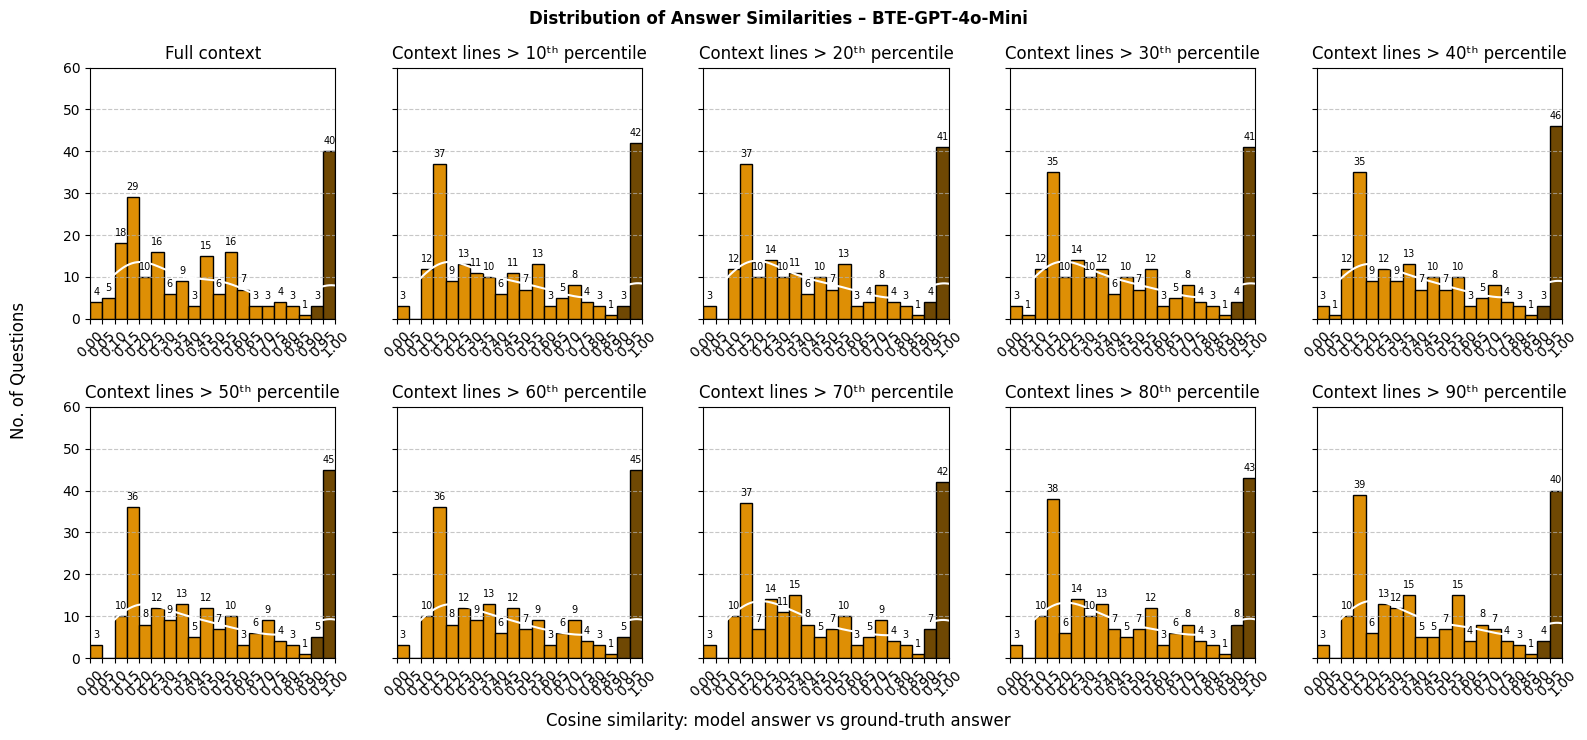

In [17]:
make_similarity_figure(gpt4omini_2, 'BTE‑GPT‑4o‑Mini',save_dir="figures/metabolite/")

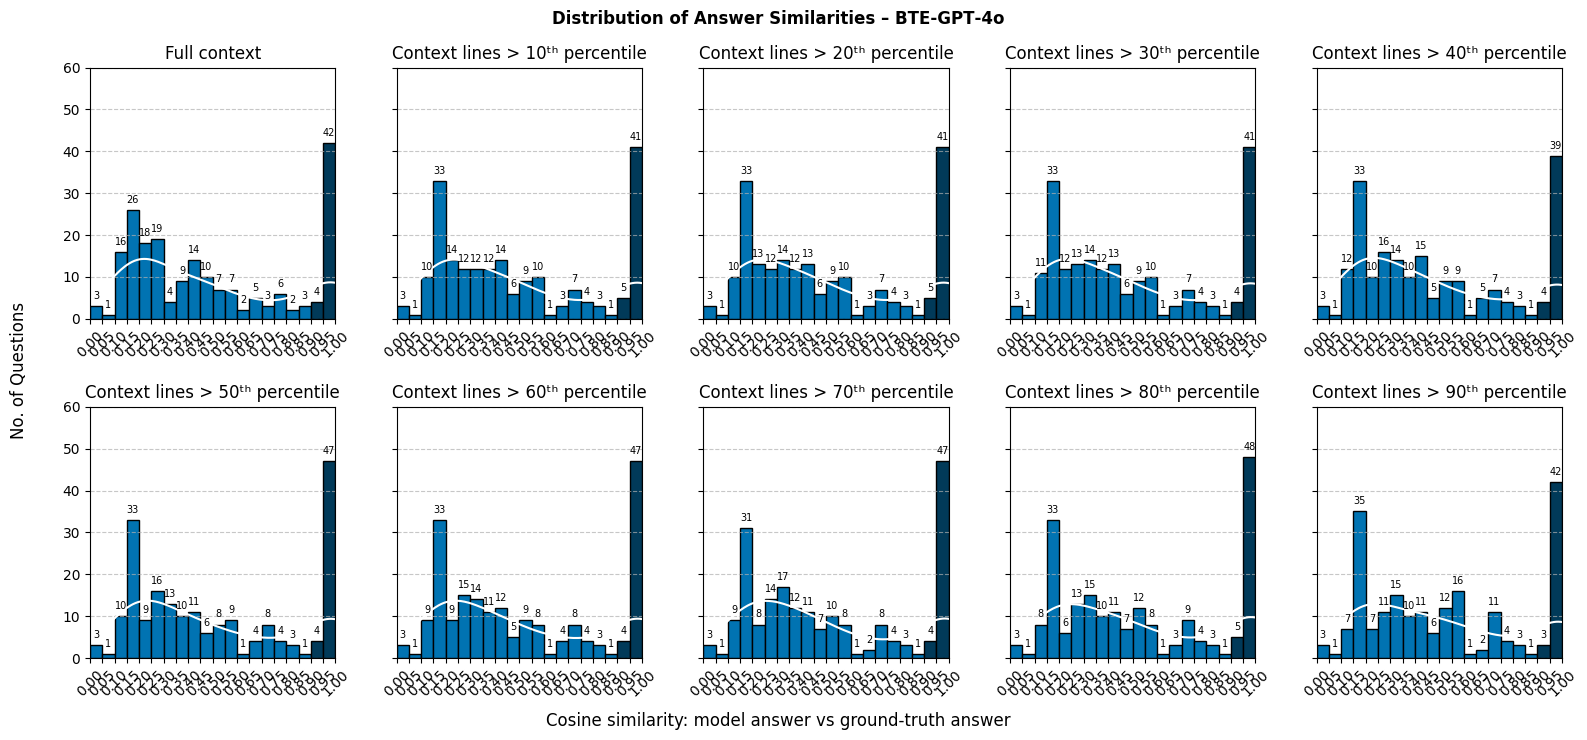

In [18]:
make_similarity_figure(gpt4o_2, 'BTE‑GPT‑4o',save_dir="figures/metabolite/")

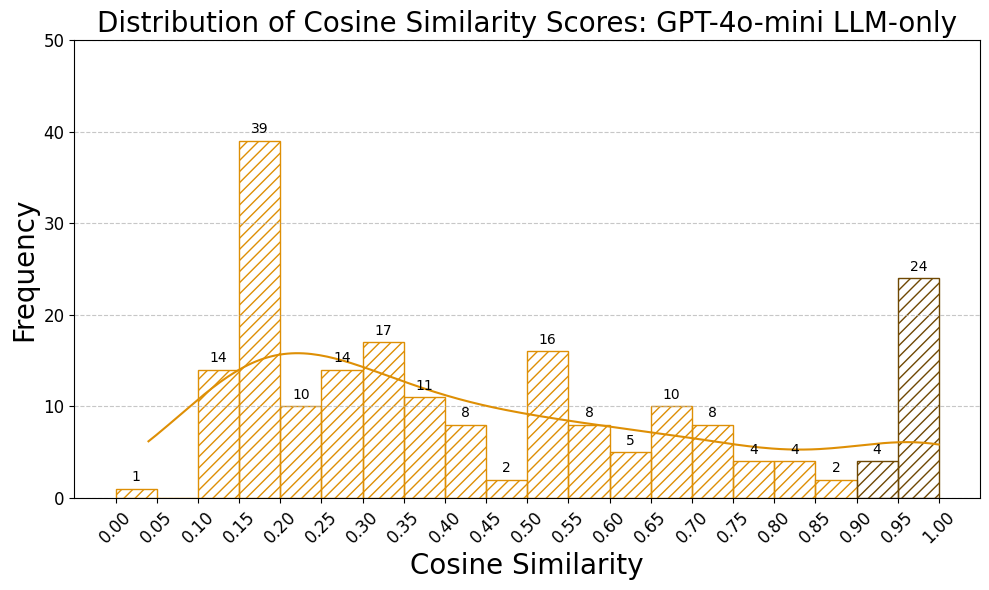

In [19]:
plot_score_distribution(
    gpt_4o_mini_prompt_testing_DMDB_chebi_metabolite,
    model_name='GPT-4o-mini LLM-only',
    save_dir="figures/metabolite"
)

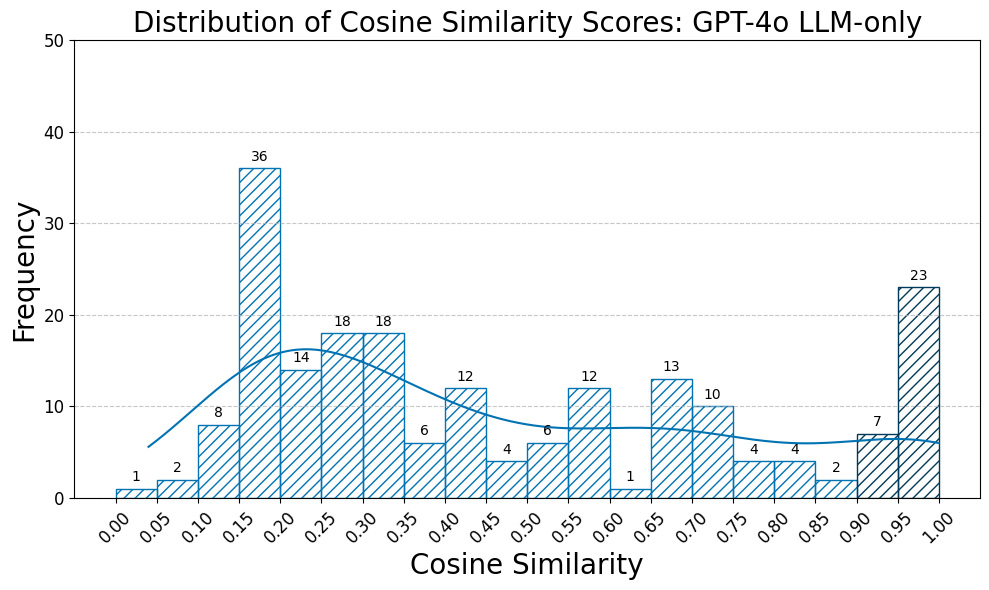

In [20]:
plot_score_distribution(
    gpt_4o_prompt_testing_DMDB_chebi_metabolite,
    model_name='GPT-4o LLM-only',
    save_dir="figures/metabolite"
)


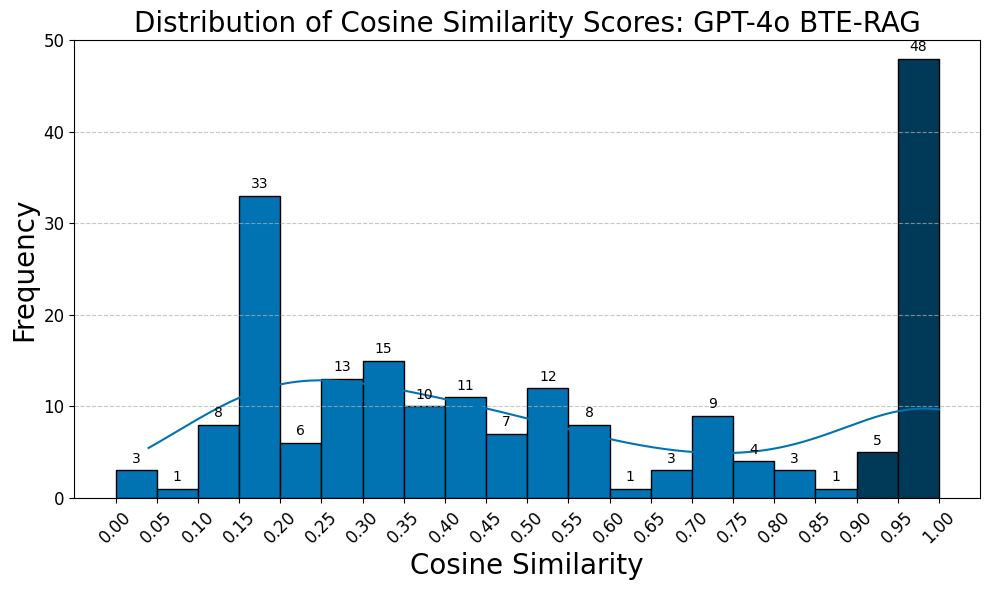

In [21]:
plot_score_distribution(
    gpt4o_2,
    score_col='cosine_similarity_sim_80',
    model_name='GPT-4o BTE-RAG',
    save_dir="figures/metabolite"
)

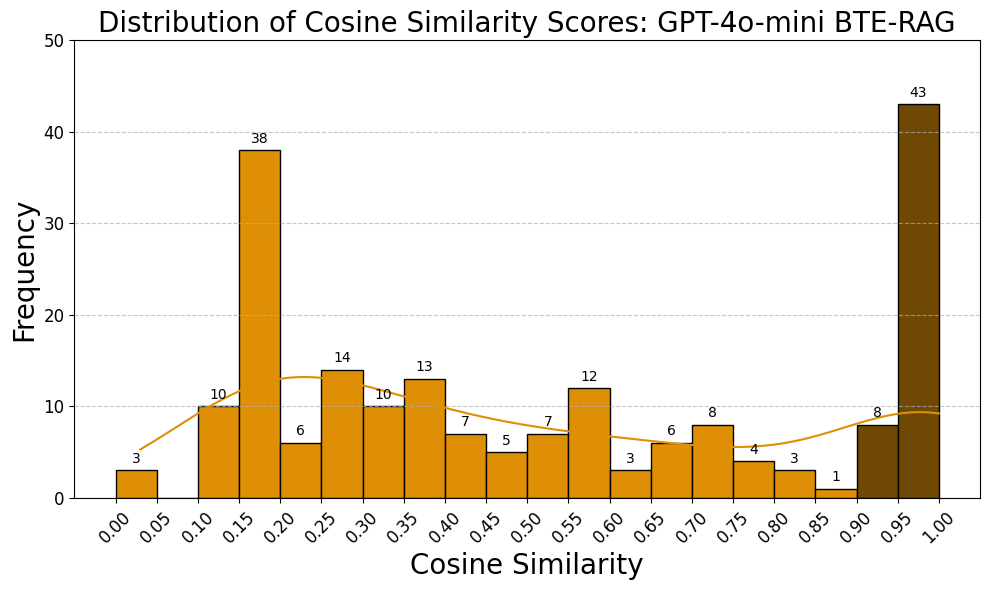

In [22]:
plot_score_distribution(
    gpt4omini_2,
    score_col='cosine_similarity_sim_80',
    model_name='GPT-4o-mini BTE-RAG',
    save_dir="figures/metabolite"
)

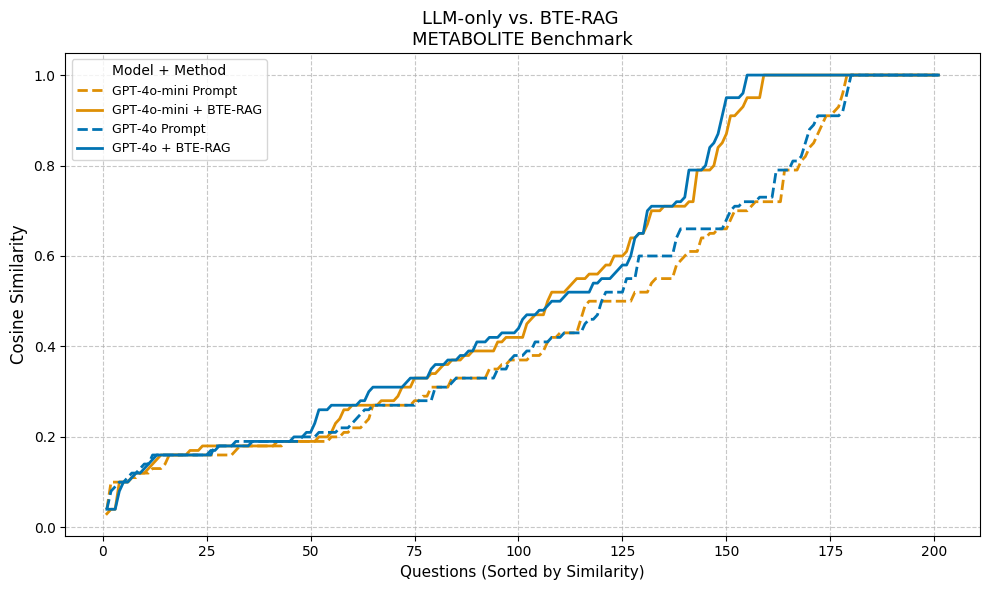

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# --- Data ---
dfs = [
    gpt_4o_mini_prompt_testing_DMDB_chebi_metabolite,  # prompt‑only
    gpt4omini_2,                                       # BTE‑RAG
    gpt_4o_prompt_testing_DMDB_chebi_metabolite,       # prompt‑only
    gpt4o_2                                            # BTE‑RAG
]
labels = [
    'GPT‑4o‑mini Prompt',
    'GPT‑4o‑mini + BTE‑RAG',
    'GPT‑4o Prompt',
    'GPT‑4o + BTE‑RAG'
]
# ≥

# --- Colors & Styles ---
palette = sns.color_palette('colorblind', 2)           # [blue, orange]
colors = [palette[1], palette[1], palette[0], palette[0]]  # mini = orange, 4o = blue
line_styles = ['dashed', 'solid', 'dashed', 'solid']       # Prompt = dashed, RAG = solid

# --- Plot ---
plt.figure(figsize=(10, 6))

for df, label, color, style in zip(dfs, labels, colors, line_styles):
    # Select correct column
    col = 'cosine_similarity' if 'Prompt' in label else 'cosine_similarity_sim_80'
    if col not in df.columns:
        continue

    data = pd.to_numeric(df[col], errors='coerce').dropna()
    sorted_vals = np.sort(data)
    ranks = np.arange(1, len(sorted_vals) + 1)

    plt.plot(
        ranks, sorted_vals,
        label=label,
        color=color,
        linestyle=style,
        linewidth=2
    )

# --- Labels & Legend ---
plt.title(
    'LLM-only vs. BTE-RAG \nMETABOLITE Benchmark',
    fontsize=13
)
plt.xlabel('Questions (Sorted by Similarity)', fontsize=11)
plt.ylabel('Cosine Similarity', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(title='Model + Method', fontsize=9)
plt.tight_layout()
plt.savefig("figures//metabolite/llm_vs_bte_rag_metabolite.svg", format="svg", bbox_inches="tight")

plt.show()

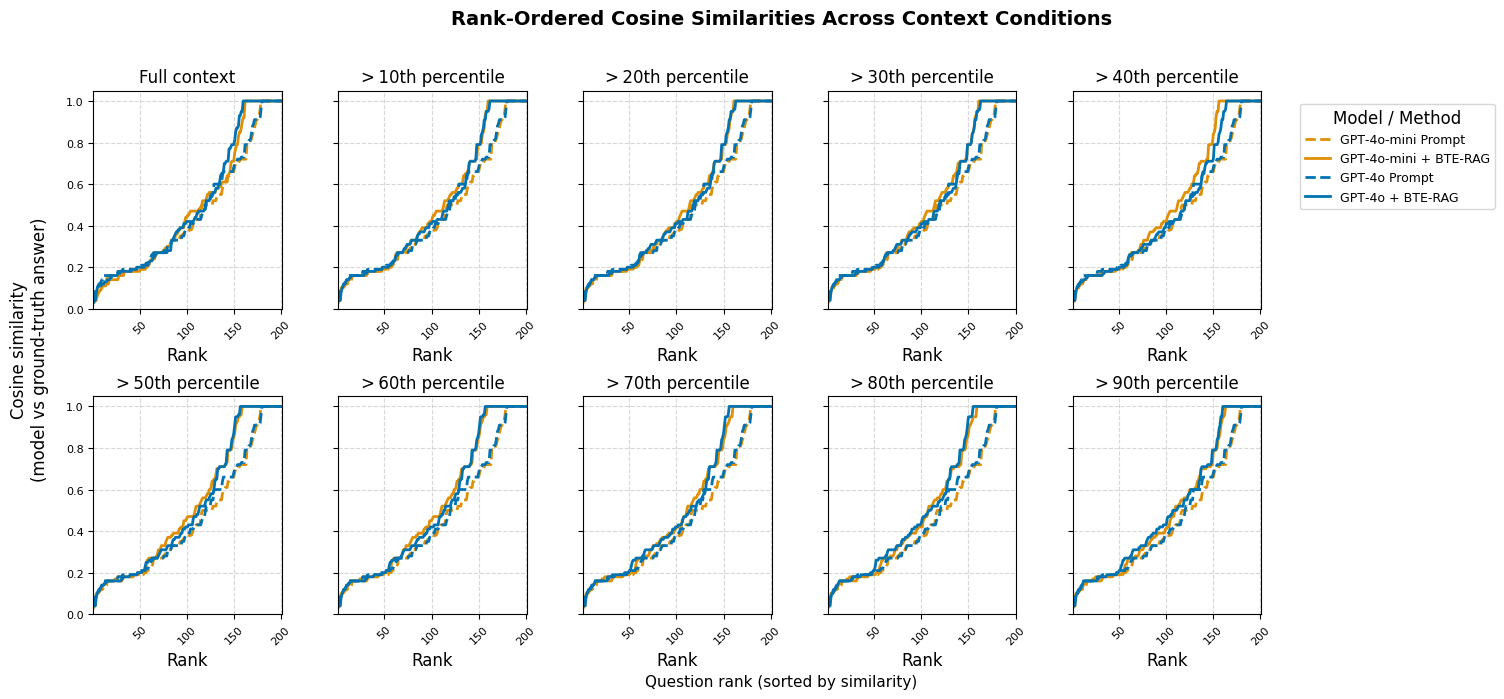

In [24]:
from math import ceil
dfs = [
    gpt_4o_mini_prompt_testing_DMDB_chebi_metabolite,  # prompt‑only
    gpt4omini_2,                                       # BTE‑RAG
    gpt_4o_prompt_testing_DMDB_chebi_metabolite,       # prompt‑only
    gpt4o_2                                            # BTE‑RAG
]
labels    = [
    'GPT‑4o‑mini Prompt',
    'GPT‑4o‑mini + BTE‑RAG',
    'GPT‑4o Prompt',
    'GPT‑4o + BTE‑RAG'
]
is_prompt  = [True, False, True, False]   # True → only has "cosine_similarity"
palette    = sns.color_palette('colorblind', 2)        # orange, blue
colors     = [ palette[1], palette[1], palette[0], palette[0]]
linestyles = ['dashed', 'solid', 'dashed', 'solid']

# ---------------------------------------------------------------------
# 2.  Metric list – Full context + 10 → 90 %
# ---------------------------------------------------------------------
score_cols = ['cosine_similarity_NC'] + [
    f'cosine_similarity_sim_{t}' for t in range(10, 100, 10)
]                                           # 10 columns

# pretty_names = ['Full context'] + [f'≥ {t} % context' for t in range(10, 100, 10)]
pretty_names = ['Full context'] + [f'> {t}th percentile' for t in range(10, 100, 10)]


# ---------------------------------------------------------------------
# 3.  Grid geometry
# ---------------------------------------------------------------------
COLS_PER_ROW = 5
n_cols = COLS_PER_ROW
n_rows = ceil(len(score_cols) / n_cols)

fig_w = 3.2 * n_cols   # inches
fig_h = 3.4 * n_rows
fig, axes = plt.subplots(
    n_rows, n_cols, figsize=(fig_w, fig_h), sharey=True, constrained_layout=False
)
axes = axes.flatten()

# ---------------------------------------------------------------------
# 4.  Plotting loop
# ---------------------------------------------------------------------
for idx, (metric, nice_label) in enumerate(zip(score_cols, pretty_names)):
    ax = axes[idx]

    # track max length across datasets to set x‑limit
    max_len = 1

    for df, lbl, c, ls, prompt_flag in zip(dfs, labels, colors, linestyles, is_prompt):
        col = 'cosine_similarity' if prompt_flag else metric
        if col not in df.columns:
            continue

        data = pd.to_numeric(df[col], errors='coerce').dropna().sort_values()
        if data.empty:
            continue

        ranks = np.arange(1, len(data) + 1)
        max_len = max(max_len, len(data))

        ax.plot(
            ranks, data.values,
            label=lbl,
            color=c, linestyle=ls, linewidth=2
        )

    ax.set_title(nice_label, fontsize=12, pad=6)
    ax.set_xlim(1, max_len)
    ax.set_ylim(0, 1.05)
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.set_xlabel('Rank', fontsize=12)
    ax.tick_params(axis='x', rotation=45, labelsize=8)
    ax.tick_params(axis='y', labelsize=8)

# hide any unused axes (if len(score_cols) < n_rows*n_cols)
for ax in axes[len(score_cols):]:
    ax.set_visible(False)

# ---------------------------------------------------------------------
# 5.  Global labels, title, legend, and margin tweaks
# ---------------------------------------------------------------------
fig.subplots_adjust(
    left=0.07, right=0.80,     # leave room for legend on the right
    bottom=0.11, top=0.88,
    wspace=0.30, hspace=0.40
)

fig.suptitle(
    'Rank‑Ordered Cosine Similarities Across Context Conditions',
    fontsize=14, fontweight='bold', y=1
)
fig.supxlabel('Question rank (sorted by similarity)', fontsize=11, y=0.0)
fig.supylabel('Cosine similarity\n(model vs ground‑truth answer)', fontsize=12, x=0.03,  y=0.5,    # centered vertically
    va='center', ha = 'center',
    rotation=90)

# One consolidated legend outside the grid
handles, legends = axes[0].get_legend_handles_labels()
fig.legend(
    handles, legends,
    title='Model / Method',
    fontsize=9, title_fontsize=12,
    loc='upper left',
    bbox_to_anchor=(0.82, 0.87)
)

fig.savefig('figures/metabolite/ranked_similarity_curves.svg')
# fig.savefig('ranked_similarity_curves.png', dpi=300)

plt.show()